In [1]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F, Sum
import math

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from utils.utils import ars

qid = 1558
q = Query.objects.get(pk=qid)


import matplotlib as mpl

mpl.rcParams['font.family'] = ['sans-serif'] # default is sans-serif
mpl.rcParams['font.serif'] = ['Arial','Verdana']


In [2]:

p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p)

techs = Technology.objects.filter(project=p).exclude(
    name__in=["Bioenergy","Geological Storage","Blue Carbon","Ethics & Morals"]
)
#techs = Technology.objects.filter(project=p)

print(techs)


trdocs = set(list(pdocs.filter(
    docownership__relevant=1,
    docownership__query__technology__in=techs
).values_list('UT',flat=True)))


ttdocs = set(list(Doc.objects.filter(
    technology__in=techs,    
).exclude(query__qtype='MN').values_list('UT',flat=True)))

<QuerySet [<Technology: BECCS>, <Technology: Ocean Alkalinisation>, <Technology: Afforestation/reforestation>, <Technology: Biochar>, <Technology: DACCS>, <Technology: Ocean fertilisation>, <Technology: Soil Carbon Sequestration>, <Technology: Enhanced Weathering>, <Technology: NETs - General>]>


In [3]:


print(len(trdocs))
print(len(ttdocs))

allreldocs =  Doc.objects.filter(
    UT__in=trdocs.union(ttdocs)
)

pqs = Query.objects.filter(
    project=p,
    
)

pdocs = Doc.objects.filter(
    id__in=list(set(list(pdocs.values_list('id',flat=True))))
)


print("Stage 1: {}".format(pdocs.distinct().count()))
print("Stage 2: {}".format(allreldocs.count()))

print(allreldocs.order_by('PY').first().PY)
print(allreldocs.order_by('PY').first().title)

print(allreldocs.filter(PY__lt=1990).count())

1909
247
Stage 1: 97726
Stage 2: 2092
0
Desalination as a Negative Emissions Technology
10


In [4]:
nq, created = Query.objects.get_or_create(
    project=p,
    title="All Relevant NETS docs",
    text="[Auto generated]",
    creator=User.objects.get(username="galm") 
)
q.save()

for d in allreldocs:
    d.query.add(nq)
    
nq.r_count = nq.doc_set.count()
nq.save()

In [5]:
nq, created = Query.objects.get_or_create(
    project=p,
    title="All Relevant NETS docs pre 2006",
    text="[Auto generated]",
    creator=User.objects.get(username="galm") 
)
q.save()

for d in allreldocs.filter(PY__lt=2006,PY__gt=0):
    d.query.add(nq)
    
nq.r_count = nq.doc_set.count()
nq.save()

In [6]:
qdocs = Doc.objects.filter(query=q)
ard_ids = allreldocs.values_list('UT',flat=True)

badocs = qdocs.exclude(UT__in=ard_ids)

badocs[0].query.all()

<QuerySet [<Query: BioEn Potential both>, <Query: BioEn Potential WoS>, <Query: beccs19_summary_1>, <Query: beccs20_summary_1>, <Query: NETS_scopus_retry_y1>, <Query: BioEn Potential Scopus>, <Query: beccs17_summary_1>, <Query: Bioenergy>, <Query: climate_all>, <Query: scopus_all>, <Query: Bioenergy Scopus>, <Query: Bioenergy Both>, <Query: NETS_all_relevant>, <Query: wos_all>, <Query: wos_all_2016>, <Query: climate all old AR6>, <Query: wos_all_updated>, <Query: climate all AR6>]>

In [7]:
bypy = allreldocs.filter(
       PY__in=range(1987,2017)
).values('PY').annotate(
    n = Count('UT', distinct=True)
).order_by('PY')

for py in bypy:
    for ar in ars:
        if py['PY'] in ar['years']:
            py['ar'] = ar['n']
            py['ar_name'] = ar['name']

bypy = pd.DataFrame.from_dict(list(bypy))

bypy.head()

bypy.tail()


,PY,ar,ar_name,n
22,2012,5,AR5,168
23,2013,5,AR5,199
24,2014,6,AR6,204
25,2015,6,AR6,220
26,2016,6,AR6,278


In [8]:
doc_dict = []

ts = techs

#allreldocs = Doc.objects.filter(query=q)
pys = list(range(1986,2017))
for t in ts:
    for py in pys:
        ydocs = allreldocs.filter(PY=py)
        trdocs = set(list(ydocs.filter(
            query__technology=t,docownership__relevant=1,docownership__query__technology=t
        ).values_list('UT',flat=True)))
        ttdocs = set(list(ydocs.filter(
            technology=t
        ).values_list('UT',flat=True)))
        tdocs = Doc.objects.filter(
            UT__in=trdocs.union(ttdocs)
        )
        d = {
            'Technology': t.name,
            'PY': py,
            'n': tdocs.count()
        }
        doc_dict.append(d)
        
for py in doc_dict:
    for ar in ars:
        if py['PY'] in ar['years']:
            py['ar'] = ar['n']
            py['ar_name'] = ar['name']

        
df = pd.DataFrame.from_dict(doc_dict)

techorder = list(techs.order_by('-ndocs').values_list('name',flat=True))


df['Technology'] = pd.Categorical(
    df['Technology'],
    techorder
)

df['ysum'] = df['n'].groupby(df['PY']).transform('sum')

df['share'] = df['n'] / df['ysum'] * 100

In [9]:
df[(df['PY']<1990) & (df['n']>0)]
#df.head()

,PY,Technology,ar,ar_name,n,ysum,share
65,1989,Afforestation/reforestation,1,AR1,1,1,100.0


In [10]:

ardf = df[['Technology','ar_name','n']].groupby(['ar_name','Technology']).sum()

ardf = ardf.reset_index()

ardf['ysum'] = ardf['n'].groupby(ardf['ar_name']).transform('sum')

ardf['share'] = ardf['n'] / ardf['ysum'] * 100

In [11]:
df

,PY,Technology,ar,ar_name,n,ysum,share
0,1986,BECCS,1,AR1,0,0,NaN
1,1987,BECCS,1,AR1,0,0,NaN
2,1988,BECCS,1,AR1,0,0,NaN
3,1989,BECCS,1,AR1,0,1,0.000000
4,1990,BECCS,1,AR1,0,0,NaN
5,1991,BECCS,2,AR2,0,13,0.000000
6,1992,BECCS,2,AR2,0,7,0.000000
7,1993,BECCS,2,AR2,0,11,0.000000
8,1994,BECCS,2,AR2,0,6,0.000000
9,1995,BECCS,3,AR3,0,14,0.000000


/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


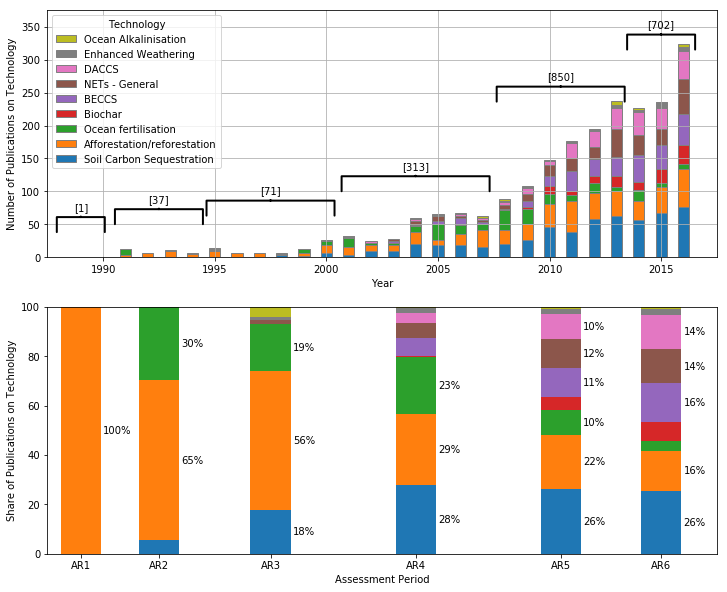

In [12]:
syear = 1986
xmin = 1.5


plt.rcParams["figure.figsize"] = [12,10]

fig, axs = plt.subplots(2,1)

ax = axs[0]

ax2 = axs[1]

pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)#.fillna(0)


pdf.plot.bar(
    stacked=True, 
    ax=ax,
    legend=False,    
    lw=1,
    edgecolor='grey'#,
    #align='center'
)



handles, labels = ax.get_legend_handles_labels()

ylabs = [1990,1995,2000,2005,2010,2015]
yts = [x-syear for x in ylabs]


ax.xaxis.set_ticks(yts)
ax.xaxis.set_ticklabels(ylabs)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.legend(handles[::-1], labels[::-1],title='Technology')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications on Technology')

ax.grid(True)

ax.set_xlim(xmax=2016-syear+1.5)
ax.set_xlim(xmin=xmin)
ax.set_ylim(ymax=375)

mids = []

for name, group in bypy.groupby('ar_name'):
    count = "[{}]".format(group['n'].sum())
    miny = group['PY'].min() - syear
    maxy = group['PY'].max() - syear
    width = maxy-miny + 1.4
    if name=="AR1":
        width = width+1
    bwidth = 1.8
    mid = group['PY'].median() - syear
    mids.append(mid)
    maxn = group['n'].max() + 60
    #ax.text(mid,maxn,count,ha="center")
    ar = group['ar'].max()
    ax.annotate(
        count,
        xy=(mid,maxn),
        xytext=(mid,maxn+10),
        ha="center",
        arrowprops=dict(arrowstyle='-[, widthB={}, lengthB=1.5'.format(width), lw=2.0)
    )
    art = ardf[ardf['ar_name']==name]
    b = 0
    h = 0
    for t in techorder:
        v = art[art['Technology']==t]
        if not v.empty:
            v = float(v['share'])
            ax2.bar(
                mid,v,bottom=b,align="center",
                width=bwidth,color=handles[h].patches[0]._facecolor
            )        
            if v > 10:
                ax2.text(mid+bwidth*0.5+0.1,b+v*0.5,"{}%".format(round(v)),va="center")
            b+=v
        h+=1

ax = ax2

for tick in ax.get_xticklabels():
    tick.set_rotation(0)


legend = ax.legend()#handles[::-1], labels[::-1],title='Technology')
#legend.remove()

ax.xaxis.set_ticks(mids)
ax.xaxis.set_ticklabels(["AR1","AR2","AR3","AR4","AR5","AR6"])

ax.set_xlabel('Assessment Period')
ax.set_ylabel('Share of Publications on Technology')

ax.set_xlim(xmax=2016-syear+1.5)
ax.set_xlim(xmin=xmin)

plt.savefig('plots/general/all_ars.png',bbox_inches='tight') 
plt.savefig('plots/general/all_ars.eps',bbox_inches='tight') 
plt.savefig('plots/general/all_ars.svg',bbox_inches='tight') 

plt.show()




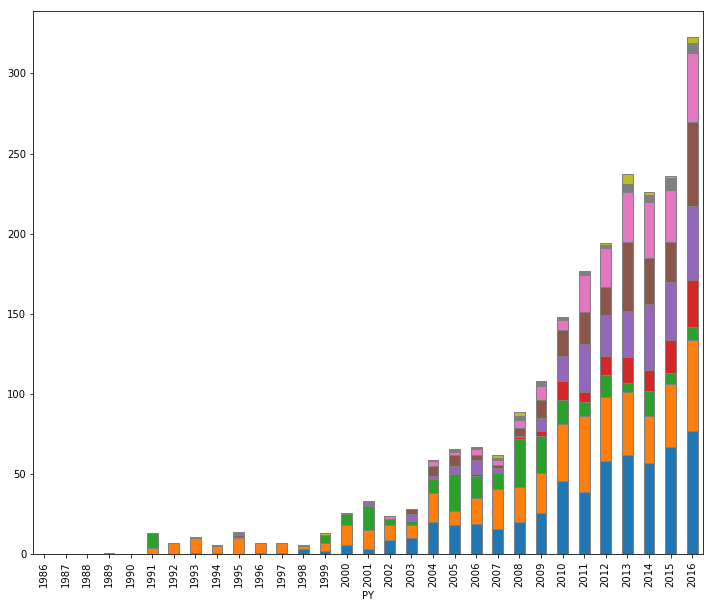

In [13]:
pdf.plot.bar(
    stacked=True, 
    #ax=ax,
    legend=False,    
    lw=1,
    edgecolor='grey'#,
    #align='center'
)
plt.show()


In [14]:
ardf.groupby('ar_name').sum()

,n,ysum,share
ar_name,,,
AR1,1,9,100.0
AR2,37,333,100.0
AR3,73,657,100.0
AR4,339,3051,100.0
AR5,953,8577,100.0
AR6,785,7065,100.0


In [15]:
import matplotlib.patches as mpatches

pdf = bypy.set_index('PY')
colors = {
    0: '#8dd3c7', 
    1: '#d53e4f', 
    2: '#fc8d59', 
    3: '#fee08b', 
    4: '#e6f598', 
    5: '#99d594', 
    6: '#3288bd'
}

#d53e4f
#fc8d59
#fee08b
#e6f598
#99d594
#3288bd

#pdf['n'].plot.bar(color=[colors[int(x)] for x in list(pdf['ar'])])

#fig, ax = plt.subplots()

ax = axs[0]

ax.grid(True)

ax.bar(
    bypy.PY,
    bypy.n, 
    lw=1,
    edgecolor='grey',
    color=[colors[int(x)] for x in list(pdf['ar'])] 
)

handles = []
labels = []
for name, group in bypy.groupby('ar_name'):
    print(name)
    count = "[{}]".format(group['n'].sum())
    mid = group['PY'].median()
    maxn = group['n'].max() + 15
    ax.text(mid,maxn,count,ha="center")
    ar = group['ar'].max()
    handles.append(mpatches.Patch(color=colors[ar], label=name))
    
ax.legend(handles=handles, title='Assessment Period')
    
#plt.legend(handles=handles, title="Assessment Period")
    
ax.set_ylim(ymax=300) 


ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications')
plt.savefig('plots/general/all_ars.png',bbox_inches='tight') 
plt.show()

AR1
AR2
AR3
AR4
AR5
AR6


In [16]:
plt.rcParams["figure.figsize"] = [12,7.5]

pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)

fig, axs = plt.subplots(1,2)

ax = axs[0]

pdf.plot.bar(
    stacked=True, 
    ax=ax,
    legend=False,    
    lw=1,
    edgecolor='grey'
)

handles, labels = ax.get_legend_handles_labels()
#lpos = (0.85,2.5)

#ax.locator_params(nbins=10, axis='x')
#ax.tick_params(direction='out', length=6, width=2, colors='r',axis='x')

ax.xaxis.set_ticks([2,7,12,17,22,27])
ax.xaxis.set_ticklabels([1990,1995,2000,2005,2010,2015])

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.legend(handles[::-1], labels[::-1],title='Technology')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications on Technology')

ax.grid(True)

ax.set_xlim(xmax=29.5)

#plt.savefig('plots/general/by_tech.png',bbox_inches='tight') 

#plt.show()



(-0.5, 29.5)

In [17]:
tsums = []

for name, group in df.groupby('Technology'):
    gsum = group['n'].sum()
    try:
        g11 = int(group[group['PY']==2011]['n'])
    except:
        g11 = 0
    try:
        g16 = int(group[group['PY']==2016]['n'])
    except:
        g16 = 0
    growth = g16 - g11
    try:
        cagr = (math.pow((g16/g11),(1/5))-1)*100
    except:
        cagr = np.NaN
    tsum = {
        'Technology': name,
        'Sum': gsum,
        '5year_compound_annual_growth_16': cagr 
    }
    tsums.append(tsum)
    
tsummary = pd.DataFrame.from_dict(tsums)

tsummary = tsummary[tsummary['Sum']>0].sort_values('Sum',ascending=False)

tsummary.to_excel('tables/tech_totals.xlsx')

tsummary.head(15)



,5year_compound_annual_growth_16,Sum,Technology
0,14.573775,562,Soil Carbon Sequestration
1,3.933463,496,Afforestation/reforestation
4,8.924936,256,BECCS
5,21.520396,242,NETs - General
2,-2.328132,231,Ocean fertilisation
6,13.330844,222,DACCS
3,37.040631,115,Biochar
7,14.869835,42,Enhanced Weathering
8,NaN,22,Ocean Alkalinisation


In [18]:
df.to_excel('tables/tech_year_totals.xlsx')

In [19]:
ars

[{'n': 0, 'name': 'AR0', 'years': range(0, 1985)},
 {'n': 1, 'name': 'AR1', 'years': range(1985, 1991)},
 {'n': 2, 'name': 'AR2', 'years': range(1991, 1995)},
 {'n': 3, 'name': 'AR3', 'years': range(1995, 2001)},
 {'n': 4, 'name': 'AR4', 'years': range(2001, 2008)},
 {'n': 5, 'name': 'AR5', 'years': range(2008, 2014)},
 {'n': 6, 'name': 'AR6', 'years': range(2014, 9999)}]

In [20]:
plt.get_cmap('Spectral')
